# Hate Speech and Offensive Content Detection

## 1. Business Understanding
### Overview
In Kenya's digital landscape, Twitter plays a critical role in shaping public discourse, especially during election seasons and politically charged events. While it provides a platform for civic engagement, it also facilitates the spread of hate speech, tribalism, and inciting language. This content can escalate tensions and contribute to real-world conflict if left unchecked.
### Challenges
Manually moderating large volumes of tweets is inefficient and prone to bias. Current moderation systems struggle to scale and often miss localized forms of hate speech, particularly those specific to Kenyan cultural and political contexts. There is also a lack of automated tools specifically designed to detect offensive content within Kenyan tweets.
### Proposed Solution
Develop a machine learning model that can automatically categorize tweets into three classes: hate speech, offensive content, or neither. The model will serve as a content flagging tool for:
Early detection of harmful tweets during elections or national events.
Support for content moderation teams at media outlets, regulatory bodies, and social platforms.
Enhancing digital safety by tracking the evolution and spread of dangerous speech trends.
Brief Conclusion
An effective classification model tailored to the Kenyan context can reduce the spread of inciting content and improve the quality of online public discourse. This system would be vital in promoting peace, especially during sensitive periods like elections.

### Problem Statement
There is an urgent need for a localized and scalable hate speech detection system to flag inciting and offensive tweets in Kenya, particularly during political periods where online speech can incite real-world unrest.

### Objectives
To evaluate the most common terms or phrases used in inciting tweets.
To build a multi-class classification model that labels tweets as hate speech, offensive, or neither.
To evaluate model performance across different algorithms using accuracy.
To Deploy the best performing model using Streamlit

## 2 Data Understanding
The dataset used in this project, HateSpeech_Kenya.csv, was sourced from Kaggle, a well-known platform for sharing datasets and machine learning challenges. It contains approximately 48,000 tweets labeled for sentiment and hate speech, specifically focused on the Kenyan social and political context.
Key Features of the Data:
tweet: The raw text of the tweet . this forms the primary input for natural language processing and classification tasks.
label: The target variable, where 0 represents neutral content and 1 represents offensive content and 2 represent hate speech.

This dataset is directly aligned with the project goal of developing a machine learning model to detect and categorize hate speech in Kenyan tweets. The inclusion of localized language, real-world offensive content, and metadata allows the model to learn patterns specific to the Kenyan context.


### Importing Dependencies

In [46]:
# Data Manipulation
import pandas as pd
import numpy as np

# Text Preprocessing
import re
import string

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk import FreqDist
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Filter Warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Preparation
#### Loading the dataset, Mapping Class with respective Labels

In [47]:
df = pd.read_csv('HateSpeech_Kenya.csv')
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else x)
label_map = {0: 'Neutral', 1: 'Offensive', 2: 'Hate Speech'}
df['Label'] = df['Class'].map(label_map)
df.tail()


,hate_speech,offensive_language,neither,Class,Tweet,Label
48071,0,0,2,0,This is exactly what Moses Kuria & ilk are doi...,Neutral
48072,0,0,2,0,This is exactly what Kenyans are going through...,Neutral
48073,0,0,2,0,This is exactly what is wrong with this countr...,Neutral
48074,1,0,2,0,This is exactly the same thing. Well the only ...,Neutral
48075,0,1,2,0,This is exactly how Luos feel in this country ...,Neutral


### Extracting the Relevant Columns

In [ ]:
new_df = df[['Tweet', 'Class', 'Label']]
new_df.head()

,Clean_Tweet,Class,Label
0,the political elite are in desperation ordinar...,0,Neutral
1,am just curious the only people who are callin...,0,Neutral
2,username the area politicians are the one to b...,0,Neutral
3,war expected in nakuru if something is not don...,0,Neutral
4,username tells kikuyus activists that they are...,0,Neutral


### Dataset Summary

In [ ]:
new_df.info()

### Checking for Duplicates

In [53]:
new_df.duplicated().sum()  # Check for duplicates (entire DataFrame)

192

### Dro duplicates

In [ ]:
new_df.drop_duplicates(inplace=True)  # Drop duplicates

### Feature Engineering ( no.of words in a tweet, no. of charcaters, no.of sentences)

### Summary Statistics

In [56]:
new_df.describe()

,Class
count,48076.000000
mean,0.310030
std,0.588431
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


### Check if there is some anomalies between our Class and Label Features

In [57]:
features = ['Class', 'Label']
for feature in features:
    print(f"Unique values in {feature}: {new_df[feature].unique()}")

Unique values in Class: [0 1 2]
Unique values in Label: ['Neutral' 'Offensive' 'Hate Speech']


### Data Cleaning

Raw tweets often contain noise such as:
- URLs
- Mentions
- Hashtags
- Emojis and non-alphanumeric characters

We'll apply basic text preprocessing to clean the tweet data.


In [ ]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    item = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags 
    item = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alphabetic
    text = text.lower().strip()             # convert to lowercase and strip whitespace
    return text

df['Clean_Tweet'] = df['Tweet'].apply(clean_text)
df.head()

### EDA

We'll visualize class distribution, tweet lengths, and word frequencies to better understand the dataset.

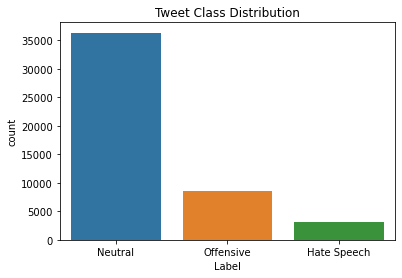

In [59]:
# Class distribution
sns.countplot(data=new_df, x='Label')
plt.title('Tweet Class Distribution')
plt.show()


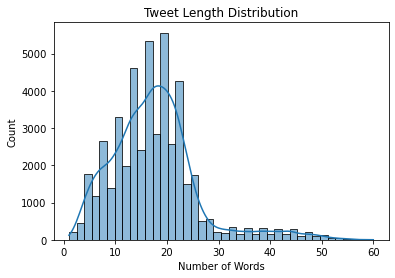

In [ ]:
## Box Plot number of characters, sentence, words in each label


### Text preprocessing
tokenizzing , selecting words with 3 or more characters, removing stop words

In [ ]:
# Tokenizer that uses a regex pattern to select words with three or more characters
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")

# List of stopwords in English
stopwords_list = stopwords.words('english')
kisw = ['na', 'ya', 'wa', 'ni', 'la', 'ka', 'ma', 'tu', 'wao', 'hii', 'hapo', 'hapo', 'hapo']
sheng = ['kazi', 'msee', 'msee', 'kazi', 'kazi', 'kazi', 'kazi', 'kazi', 'kazi', 'kazi', 'kazi']
# Combine all stopwords
stopwords_combined = set(stopwords_list + kisw + sheng)

# Stemmer using PorterStemmer Class
stemmer = PorterStemmer() 

# use lemmatizer

In [62]:
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    words = [word for word in tokens if word not in stopwords_list]
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

### performing preprocessing on the clean tweet feature

In [63]:
text_data = new_df['Clean_Tweet'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))
text_data.tail()

48071    [exactli, mose, kuria, ilk, say, neg, ethnic, ...
48072    [exactli, kenyan, go, thank, god, time, richth...
48073    [exactli, wrong, countri, kikuyu, cant, stand,...
48074    [exactli, thing, well, differ, kilifi, theyr, ...
48075    [exactli, luo, feel, countri, like, mose, kuri...
Name: Clean_Tweet, dtype: object

### Adding preprocessed tweet as a column

In [64]:
new_df["Preprocessed_Tweet"] = text_data
new_df.head()

,Clean_Tweet,Class,Label,length,Preprocessed_Tweet
0,the political elite are in desperation ordinar...,0,Neutral,13,"[polit, elit, desper, ordinari, kalenjin, susp..."
1,am just curious the only people who are callin...,0,Neutral,25,"[curiou, peopl, call, old, mad, kikuyu, kalenj..."
2,username the area politicians are the one to b...,0,Neutral,22,"[usernam, area, politician, one, blame, coz, i..."
3,war expected in nakuru if something is not don...,0,Neutral,20,"[war, expect, nakuru, someth, done, luo, given..."
4,username tells kikuyus activists that they are...,0,Neutral,18,"[usernam, tell, kikuyu, activist, target, targ..."


### Frequency Dist Of Preprocessed Words

In [65]:
frequency_dist = FreqDist(new_df['Preprocessed_Tweet'].explode())
frequency_dist

FreqDist({'usernam': 15524, 'kikuyu': 8245, 'luo': 5223, 'noreformsnoelect': 4044, 'nyakundi': 2934, 'kenya': 2855, 'peopl': 2672, 'kenyan': 2532, 'kill': 2440, 'like': 2416, ...})

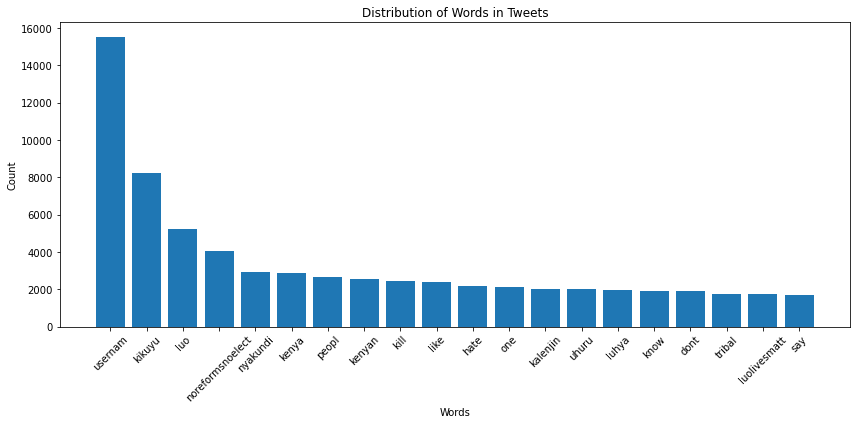

In [ ]:

# Sort the dictionary by value (descending)
sorted_dict = dict(sorted(frequency_dist.items(), key=lambda x: x[1], reverse=True))

# Take the top 20 Words
top_20 = dict(list(sorted_dict.items())[:20])

keys = [str(k) for k in top_20.keys()]
values =  list( top_20.values())

plt.figure(figsize=(12, 6))
plt.bar(top_20.keys(), top_20.values())
plt.title("Distribution of Words in Tweets")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45)  

plt.tight_layout()  
plt.show()

## Word Cloud PLot
from wordcloud import WordCloud

### Distribution of Words by LABEL/CLASS

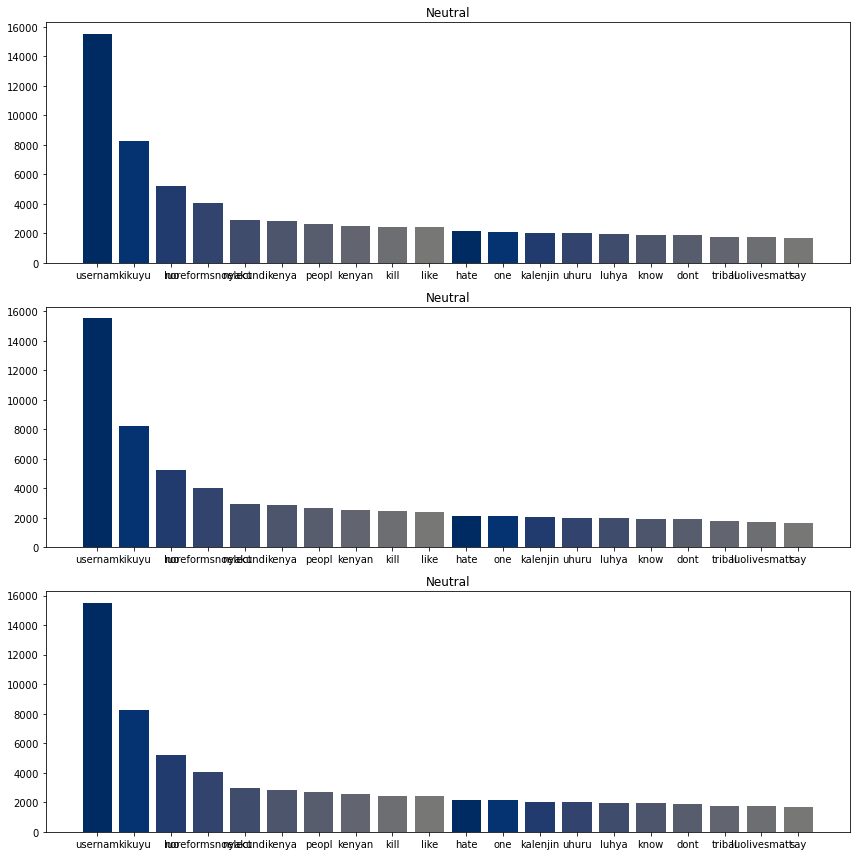

In [75]:

fig, axes = plt.subplots(nrows=3, figsize=(12, 12))

plotted_words_and_colors = {}

color_palette = sns.color_palette('cividis', n_colors=20)

data_by_label = [y for _, y in new_df.groupby('Label', as_index=False)]
for idx, label in enumerate(data_by_label):
    
    all_words_in_label = new_df.Preprocessed_Tweet.explode()
    top_20 = all_words_in_label.value_counts()[:20]
    

    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    
    ax = axes[idx]
    ax.bar(top_20.index, top_20.values, color=colors)
    ax.set_title(new_df.iloc[0].Label.title())
    
fig.tight_layout()